_Neural Data Science_
Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

* Student names: Ahmed Eldably, Aakarsh Nair, Andreas Kotzur
* LLM Disclaimer:  Chat GPT o3, Gemini, Copilot. For plotting and answer verification, and neuroscience context.

# Coding Lab 1

## Introduction

In this coding lab you get to implement a pipeline for spike detection and feature extraction, as presented in the lecture:
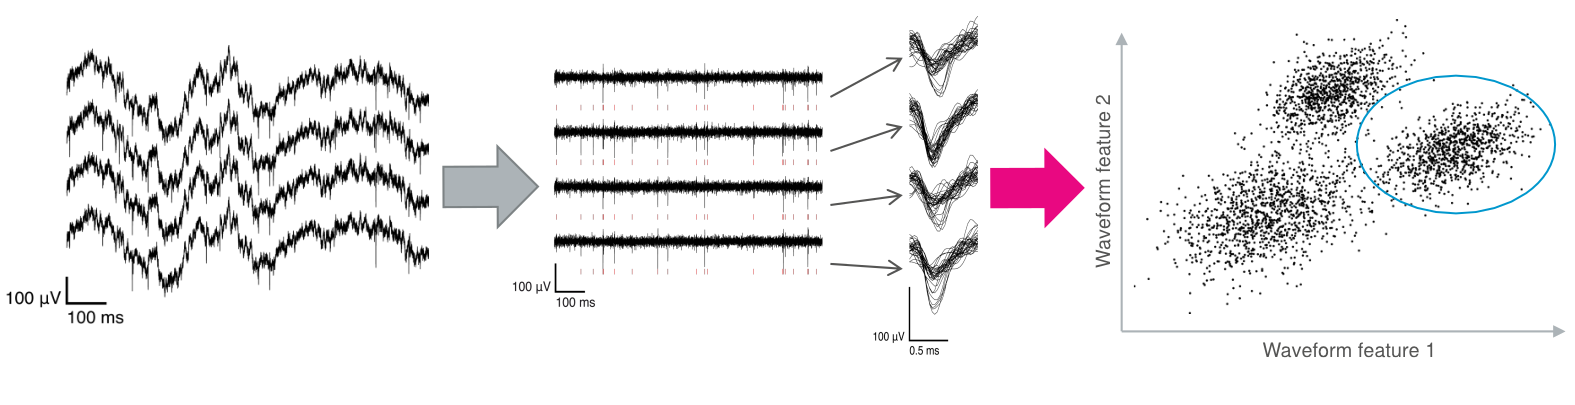

This will later be used for spike sorting (identifying which spike / waveform in the signal was caused by which neuron).

The data used in this notebook was recorded at 30kHz with a tetrode and thus contains the voltage traces of the 4 channels in μV.

_(for more information on the data acquisition, you can have a look at [Ecker et al 2014](https://doi.org/10.1016/j.neuron.2014.02.006), in particular the supplementary material. A similar pipeline is also used in [Ecker et al 2010](https://doi.org/10.1126/science.1179867). Note however that we only use a small portion of the data in this notebook and most of the experiment setup is not relevant here!)_

## Setup
- __Data__: Download the data file ```nds_cl_1.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.


Recommended folder structure:

```
.
├── data/
│   └── nds_cl_1.csv
├── notebooks
│   └── CodingLab1.ipynb
├── matplotlib_style.txt
└── requirements.txt
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from __future__ import annotations  # for Python 3.8 and below

# black is a code formatter (see https://github.com/psf/black).
# It will automatically format the code you write in the cells imposing consistent Python style.
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-04-27 18:04:39CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.31.0

sklearn: 1.6.1

matplotlib: 3.10.0
pandas    : 2.2.3
sklearn   : 1.6.1
scipy     : 1.15.1
numpy     : 2.2.2

Watermark: 2.5.0



In [2]:
# matplotlib style file
# Template for style file: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
fs = 30000.0  # sampling rate of the signal in Hz
dt = 1 / fs
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
x = pd.read_csv("../data/nds_cl_1.csv", header=0, names=cols)

In [4]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


/var/folders/_q/9l1zk1853mv45phss2fsffd00000gn/T/ipykernel_21688/514055045.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


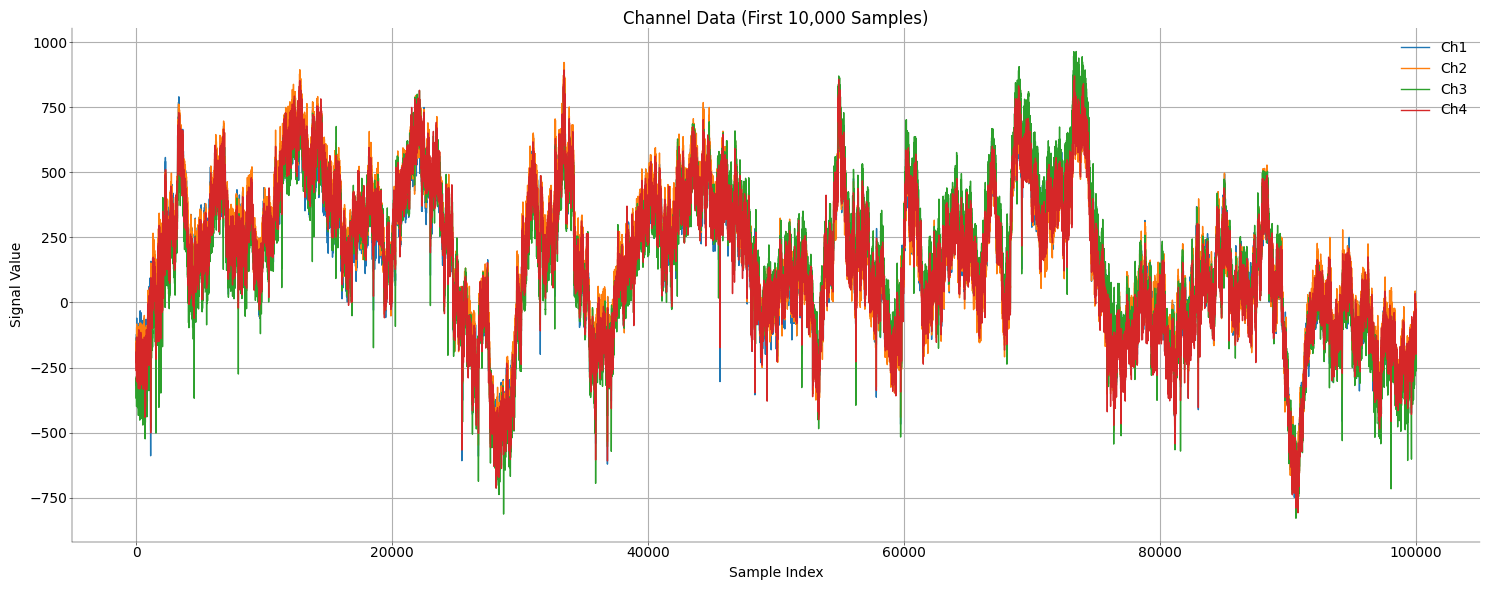

In [5]:
df_subset = x.iloc[:100000]

# Plotting
plt.figure(figsize=(15, 6))
for channel in list(df_subset.columns):
    plt.plot(df_subset[channel], label=channel)

plt.title("Channel Data (First 10,000 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>.

Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 3 pts*


In [6]:
import scipy


# %matplotlib inline
## Current Best Practice
def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 3
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """
    # -----------------------------------------------------------------
    # implement a suitable filter and apply it to the input data (1pt)
    # -----------------------------------------------------------------
    y = pd.DataFrame()
    assert 0 < low < high < fs / 2, "Invalid filter parameters"
    # Butterworth filter design
    # The filter is designed using the second-order sections (SOS) method.
    sos = scipy.signal.butter(
        N=order, Wn=[low, high], btype="band", output="sos", fs=fs
    )
    for channel in x.columns:
        y_channel_sos = scipy.signal.sosfiltfilt(sos, x[channel])
        y[channel] = y_channel_sos
    return y

In [7]:
y = filter_signal(x, fs, 500, 4000)

In [8]:
y.shape

(19199999, 4)

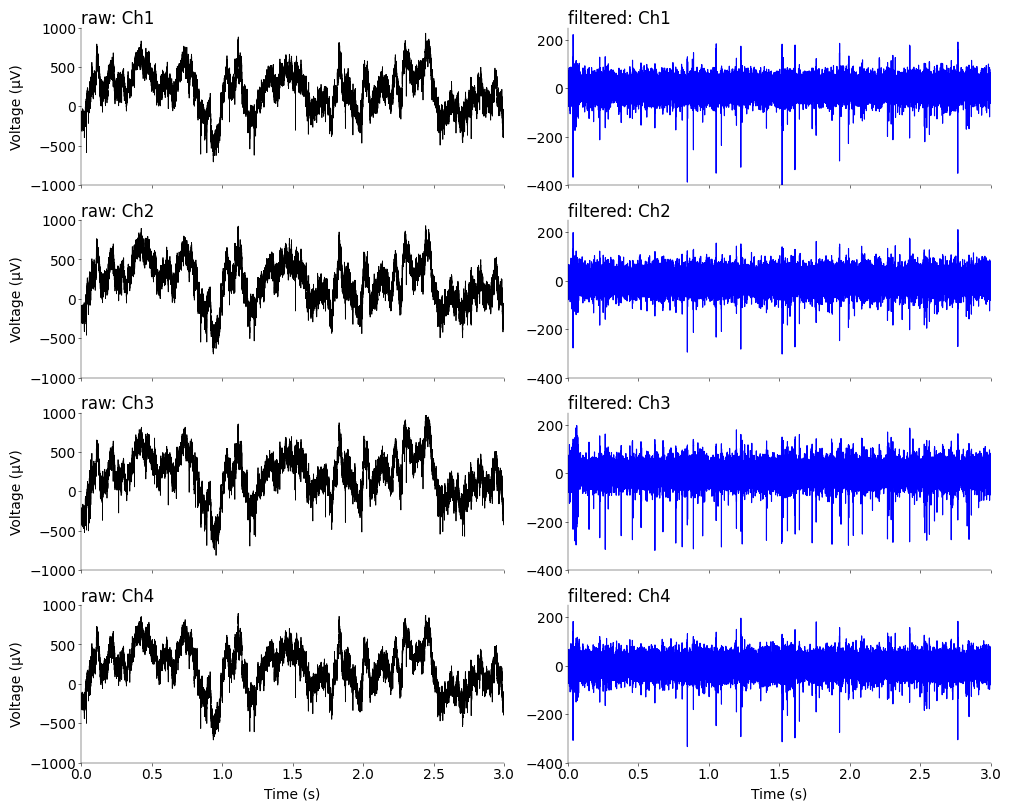

In [9]:
# Settings
T = 100000  # number of samples to plot
t = np.arange(0, T) * dt  # time vector in seconds

# Assume x and y are numpy arrays with shape (T, 4)
# x = raw data, y = filtered data
channels = ["Ch1", "Ch2", "Ch3", "Ch4"]

# Subplot layout
mosaic = [
    ["raw: Ch1", "filtered: Ch1"],
    ["raw: Ch2", "filtered: Ch2"],
    ["raw: Ch3", "filtered: Ch3"],
    ["raw: Ch4", "filtered: Ch4"],
]

# ------------------------------------------------------------------------------------
# Plot raw and filtered signals for all 4 channels and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------------

fig, ax = plt.subplot_mosaic(mosaic, figsize=(10, 8), layout="constrained", dpi=100)

# Plot each channel from DataFrames x (raw) and y (filtered)
for i, ch in enumerate(channels):
    raw_key = f"raw: {ch}"
    filt_key = f"filtered: {ch}"

    ax[raw_key].plot(t, x[ch].iloc[:T], color="black", linewidth=0.6)
    ax[filt_key].plot(t, y[ch].iloc[:T], color="blue", linewidth=0.8)

    ax[raw_key].set_xlim((0, 3))
    ax[filt_key].set_xlim((0, 3))
    ax[raw_key].set_ylim((-1000, 1000))
    ax[filt_key].set_ylim((-400, 250))

    ax[raw_key].set_ylabel("Voltage (µV)")
    ax[raw_key].set_title(raw_key, loc="left")
    ax[filt_key].set_title(filt_key, loc="left")

    if i != len(channels) - 1:
        ax[raw_key].set_xticklabels([])
        ax[filt_key].set_xticklabels([])
    else:
        ax[raw_key].set_xlabel("Time (s)")
        ax[filt_key].set_xlabel("Time (s)")

plt.show()

### Questions
1) Explain your implementation: Which filter and parameters did you choose and why?

* We used a Bandpass Butterworth filter, as it is *maximally flat* in the pass band and does not boost attenuate the signal it passes through. 

* Cutoff frequencies: 500-4000 Hz. were used as standard frequencies which were provided to us. We tried different cut-off frequencies such as 300-3000 hz. Shifting cut off frequencies led to principal components of different channels to be less aligned thus capturing different waveform dynamics on different channels principal components which seems undesirable unless one is considering modeling how neurons are measured differently be each channel.

* Order 3: It balances sharpness and stability.
* The filter was implemented using the second-order sections (sos), which are used for numerical stability.

2) Which parameters of the function can be adjusted, which are determined by the experiment setup? What is the effect of the adjustable parameters?

* Sampling frequency shouldn't be adjusted because it depends on the hardware/experimental setup. It affects the filter's maximum cut-off according to the Nyquist theory.
* Low and high cutoff frequencies could be adjusted. It defines the passband of the filter. Lowering the low includes more low-frequency noise, and increasing the high includes more high-frequency noise.
* Filter order is adjustable. It controls the steepness of the filter's transition band. Higher order = sharper cutoff, but more delay and potential instability. Lower order = smoother roll-off, but may let unwanted frequencies pass.

3) How does the filtered signal look compared to the original? Why is this helpful as preprocessing in our spike detection pipeline?

* The raw signal (left) shows large, slow fluctuations (local field potentials, baseline drift) mixed with spikes.
* The filtered signal (right) shows clearly suppressed low-frequency activity, making spikes stand out prominently.
* The preprocessing steps help by:
    * Removing slow trends and noise irrelevant to spike detection.
    * Emphasizing fast, high-frequency events like spikes.
    * Improving signal-to-noise ratio for thresholding and PCA.

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detect_spikes()```.

Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes, also **plot the threshold**.

*Grading: 4 pts*

In [10]:
from scipy.signal import find_peaks


def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: float = 1.0
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes in the signal x and compute a threshold.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: float
        a window of 'refractory period', within which there's only one spike.
        Default is 1ms but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the signal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    You can use scipy functions like find_peaks for the detection.
    Note: There are four channels in signal x.

    """
    # --------------------------------------------------------------
    # compute the robust s.d. and calculate the threshold (0.5 pts)
    # --------------------------------------------------------------

    # --------------------------
    # find all spikes (1.5 pts)
    # --------------------------
    # Compute robust standard deviation estimate (median-based)
    sigma = np.median(np.abs(x)) / 0.6745
    thrd = -N * sigma

    # Convert lockout from ms to samples
    # Take the lockout across channels
    lockout_samples = int((lockout / 1000.0) * fs)

    # Detect spikes across all channels
    all_spikes = []
    for ch in range(x.shape[1]):
        peaks, _ = find_peaks(-x[:, ch], height=-thrd, distance=lockout_samples)
        all_spikes.extend(peaks)

    # Combine, sort, and remove duplicates (if same spike across channels)
    s = np.unique(np.array(all_spikes, dtype=int))

    # Convert spike indices to time in ms
    t = (s / fs) * 1000.0

    return s, t, thrd

In [11]:
# Detect spikes from filtered signal
s, t, thrd = detect_spikes(y.values, fs=fs, N=5, lockout=1.0)

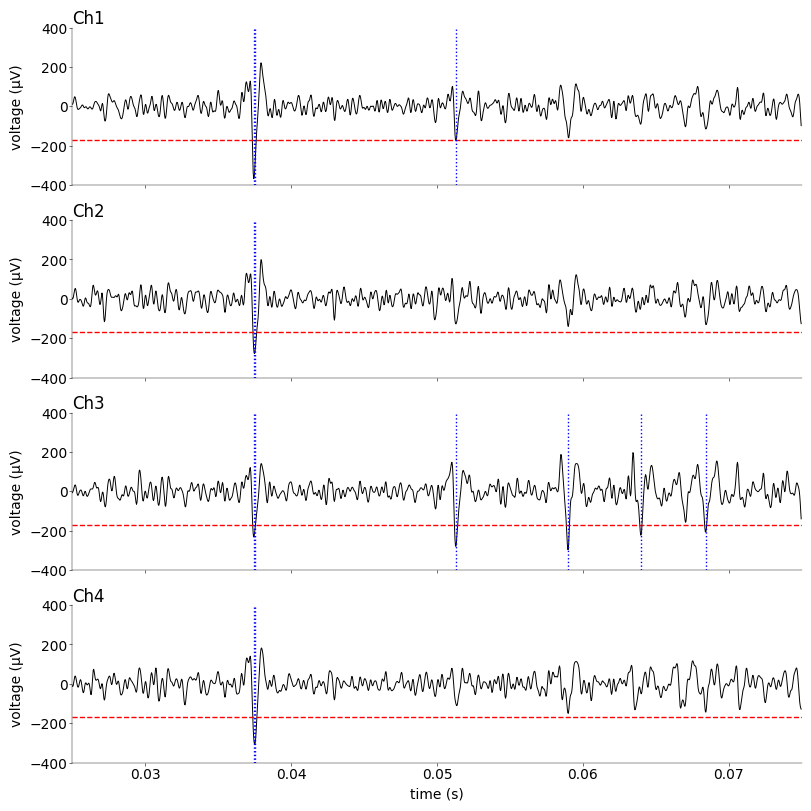

In [12]:
# Define time window for zoomed plot (in seconds)
t_start = 0.025
t_end = 0.075
start_idx = int(t_start * fs)
end_idx = int(t_end * fs)
time_window = np.arange(start_idx, end_idx) / fs

mosaic = [
    ["Ch1"],
    ["Ch2"],
    ["Ch3"],
    ["Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# ------------------------------------------------------------------------------
# plot signal, threshold and detected spikes and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------

# Loop through each channel
for i, col in enumerate(cols):
    # Get the channel's signal
    signal = y[col].iloc[start_idx:end_idx].values
    ax[col].plot(
        time_window, signal, color="black", linewidth=0.7, label="Filtered Signal"
    )

    # Add threshold line
    ax[col].axhline(thrd, color="red", linestyle="--", linewidth=1, label="Threshold")

    # Find spikes that occurred in the current channel and within this time window
    spikes_in_window = s[(s >= start_idx) & (s < end_idx)]
    for spike in spikes_in_window:
        if np.abs(y.iloc[spike, i]) > np.abs(thrd):  # spike is in this channel
            ax[col].axvline(
                spike / fs, color="blue", linestyle=":", linewidth=1, label="Spike"
            )

    # Formatting
    ax[col].set_ylim((-400, 400))
    ax[col].set_xlim((t_start, t_end))
    ax[col].set_ylabel("voltage (μV)")
    ax[col].set_title(col, loc="left")

    # Hide x-axis ticks except for bottom plot
    if col != "Ch4":
        ax[col].set_xticklabels([])
    else:
        ax[col].set_xlabel("time (s)")

plt.show()

### Questions

1) Are the detected time points well aligned with prominent extrema in the signal? Also compare your detections across channels.

*Answer:*

* Yes, the detected spike time points aligned with large negative peaks (extrema) in the filtered signal.
* The most spikes detection on channel 3, but spikes detected on other channels align well with channel 3 spikes.

3) Take one feature of the spikes and explain how that can help us identifying the source neuron of a spike (only based on visual examination of the plot).

*Answer:*
If we consider the amplitude of a spike as feature. We see that this spike is detected on multiple channels. But that the amplitude of the spike amplitude varies by the channel
on which it is detected. Thus it can act as one of the means of identifying a source neuron.

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```.

Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected.
Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 3 pts*

In [60]:
def extract_waveforms(
    x: np.ndarray, s: np.ndarray, window_size: int = 30
) -> np.ndarray:
    """Extract spike waveforms at times s (given in samples)
    from the filtered signal `xf` using a fixed window around the
    times of the spikes.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal.

    s: np.array, (n_spikes, )
        Spike time in samples.

    window_size: int, default is 30 samples

    Return
    ------

    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. (You don't have to get the exact same
        shape as we noted here. It's just the shape of w
        that can be easily retrieved via broadcasting.)


    Notes
    -----

    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

    """
    # -------------------------------
    # extract spike waveforms (1 pt)
    # -------------------------------
    half_window = window_size // 2
    n_channels = x.shape[1]
    waveforms = []

    for spike_time in s:
        # Skip if spike is too close to edge
        if spike_time - half_window < 0 or spike_time + half_window > x.shape[0]:
            continue
        # Extract waveform: shape (window_size, n_channels)
        snippet = x[spike_time - half_window : spike_time + half_window, :]
        waveforms.append(snippet)

    return np.array(waveforms)

Plot first 100 spike waveforms

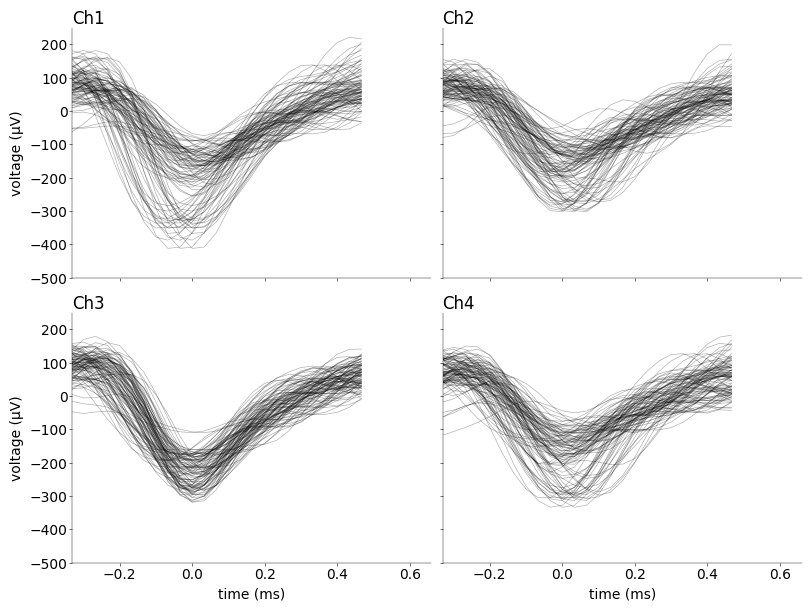

In [61]:
# ---------------------------------------------------------------------
# plot first and largest 100 spikes and answer the questions (1+1 pts)
# ---------------------------------------------------------------------

# first 100 spikes
first_100_spikes = s[:100]
filtered_signal = y.to_numpy()
wave_forms = extract_waveforms(x=filtered_signal, s=first_100_spikes)

mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]

fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

window_size = wave_forms.shape[1]
time_vector = (np.arange(window_size) - window_size // 2) * (1000 / fs)  # ms


# Plot each waveform in each channel
for i, col in enumerate(cols):
    for wf in wave_forms:
        ax[col].plot(time_vector, wf[:, i], color="black", alpha=0.3, linewidth=0.5)

    # labeling etc
    ax[col].set_ylim((-500, 250))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (μV)")
    else:
        ax[col].set_yticklabels([])

Plot largest 100 spike waveforms

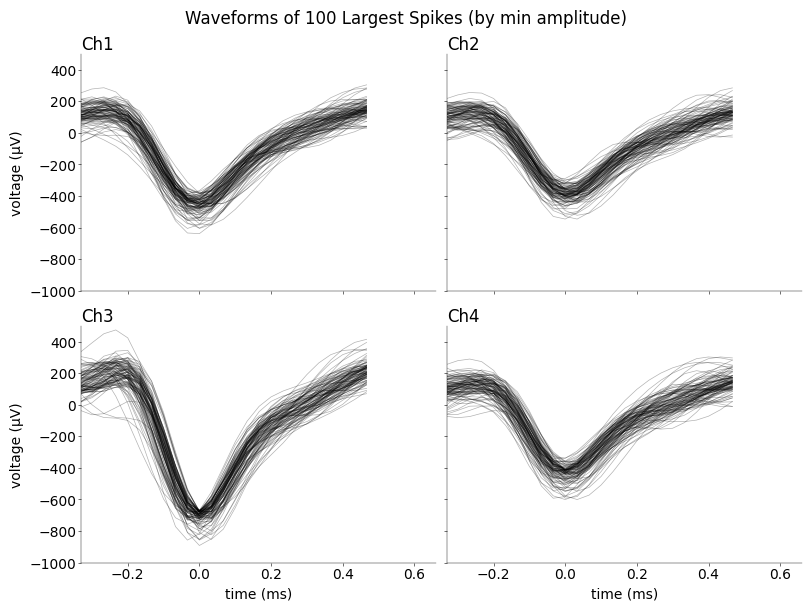

In [62]:
# largest 100 spikes

# Compute the minimum amplitude across channels at each spike time
amplitudes = np.min(filtered_signal[s, :], axis=1)  # shape (n_spikes,)

# sort by most negative
largest_100_indices = np.argsort(amplitudes)[:100]
largest_100_spikes = s[largest_100_indices]

# Extract waveforms for these 100 largest spikes
largest_wave_forms = extract_waveforms(x=filtered_signal, s=largest_100_spikes)


fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

for i, col in enumerate(cols):
    for wf in largest_wave_forms:
        ax[col].plot(time_vector, wf[:, i], color="black", alpha=0.3, linewidth=0.5)

    # labeling etc
    ax[col].set_ylim((-1000, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (μV)")
    else:
        ax[col].set_yticklabels([])
plt.suptitle("Waveforms of 100 Largest Spikes (by min amplitude)");

### Questions

1) Describe the shape of the spikes.

*Answer:*

The spikes seem to have a sharp descent to the spike peak then a slower return their resting potential. The overall shapes are similar despite their amplitudes varying accross channels.
For example channel-3 measures a greater amplitude than the other channels but the shape of the waveforms are similar. 

2) Do the waveforms tend to be similar? If spikes have a similar waveform, what could that mean - and what does it mean if the waveforms look different?

*Answer:*

For the largest 100 spikes, the spikes detected on the the various channel look to be roughly similar, with greater variance before and after the spike has occurred.

If the waveforms for different spike looks similar, then this could mean that they are coming
from the same source neuron, as it could reflect the biophysical properties of the neuron such as size, membrane, ion channels, and its position relative to the electrode. 

If the the waveforms for different spikes look different, then it could mean that they are coming from different source neurons, or that they are a result of change in experimental conditions.

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()```. You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs. Also return the obtained parameters of the PCA

For one channel, plot the mean and the first three principal axes as calculated by the PCA in the feature space. Interprete them in light of the plots in the previous tasks.

For all pairwise combinations of channels, plot the resulting features of the 1st PCs as scatter plots against each other. Do you see clusters visually?

*Grading: 6 pts*

## PCA
### Questions (1 pt)

1) If we input the data from each channel separately to a PCA, what are the feature dimension of the input?

**Answer**:
We have segmented the data after spike detection into a tensor or shape $4 \text{ channels} \times 30 \text{ samples per window} \times \text{ number of spikes detected}$.  When we run PCA for each channel 
separately, map our window $R^{30} \to R^{3}$. Thus the input feature dimension is 30 for a spike while the output dimension is $3$. Thus by using the coordinates of the principal components we are able to successfully reduce the number of dimensions characterizing a detected spike.
Thus we have
* Input feature dimension per channel = 30 
* Output dimension per channel = 3


2) Therefore, what do the Principal Axes the PCA computes represent?

**Answer**:
When PCA is applied separately to each channel, it returns **three principal axes (components)** per channel.  
Each axis is a 30-sample waveform that captures one dominant mode of variation in the spike shapes:

1. **Orthogonal directions**  
   The three axes are orthogonal in the $30$-dimensional waveform space, so each component carries unique (non-redundant) information.

2. **Ordered by explained variance**  
   $\text{PC}_1$ explains the largest amount of variance across spikes, $\text{PC}_2$ the second-largest, and $\text{PC}_3$ the third.

3. **Eigenvectors of the covariance matrix**  
   Let $X\!\in\!\mathbb{R}^{N\times30}$ be the matrix of mean-centered spike snippets.  
   The principal axes are the eigenvectors of the covariance matrix  
    $$
     C \;=\; \frac{1}{N}\,X^{\top}X .
    $$


In short, each principal axis is a *prototypical spike waveform*; any individual spike can be approximated as a linear combination of these three shapes with its PCA scores as coefficients.


3) Does it make sense to apply preprocessing steps, such as normalization? Have a look at the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). What is applied by default?

**Answer:**

Because every feature is a voltage sample expressed in µV, all features already share the same physical scale. Extra standardisation (StandardScaler) would therefore only re-weight time points and is optional rather than required. 

*sklearn.decomposition.PCA* automatically centres each feature (subtracts its mean) but does not rescale the variance (whiten=False). Centring is crucial; without it PCA could treat the overall mean offset as a dominant direction of “variance” and yield sub-optimal components.

In [63]:
"""Solution"""

from sklearn.decomposition import PCA


def extract_features(w: np.ndarray) -> np.ndarray:
    """Extract features for spike sorting from the waveforms w.

    Do PCA on the waveforms of each channel separately,
    then concatenate the first three principal components
    of each channels into one numpy array (`b`).


    Parameter
    ---------

    w: np.ndarray, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.


    Return
    ------

    b: np.ndarray, (n_spikes, n_feature)
        the transformed data
    means: np.ndarray, (n_channels, length_window)
        means per channel
    principal_components: np.ndarray, (n_channels, 3, length_window)
        the 'principal axes' obtained by the pca


    Notes
    -----

    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """

    # ----------------------------------------------
    # obtain first 3 principle components (1.5 pts)
    # ----------------------------------------------

    # -----------------------------------------------------------------------------------------------------
    # Print the fraction of variance explained by the three components combined for each channel (0.5 pts)
    # -----------------------------------------------------------------------------------------------------
    n_spikes, window_len, n_channels = w.shape

    # Storage
    features = []
    means = np.zeros((n_channels, window_len))
    principal_components = np.zeros((n_channels, 3, window_len))

    for ch in range(n_channels):
        # Get the waveforms per channel
        channel_data = w[:, :, ch]

        # Compute the mean waveform, we explictly center the data,
        # for documentation purposes, but PCA does this
        # automatically in sklearn.
        mean = channel_data.mean(axis=0)
        means[ch] = mean

        # PCA data
        centered_data = channel_data - mean

        # Fit PCA
        pca = PCA(n_components=3)
        transformed = pca.fit_transform(centered_data)  # shape (n_spikes, 3)

        # Save components: shape (3, window_len)
        principal_components[ch] = pca.components_

        # Save features for this channel
        features.append(transformed)

        # Print variance
        var_exp = pca.explained_variance_ratio_.sum()
        print(
            f"Channel {ch + 1}: Variance explained by first 3 components = {var_exp:.2%}"
        )

    # Concatenate feature from all channels
    b = np.concatenate(features, axis=1)

    return b, means, principal_components

Channel 1: Variance explained by first 3 components = 84.11%
Channel 2: Variance explained by first 3 components = 77.21%
Channel 3: Variance explained by first 3 components = 79.78%
Channel 4: Variance explained by first 3 components = 78.41%


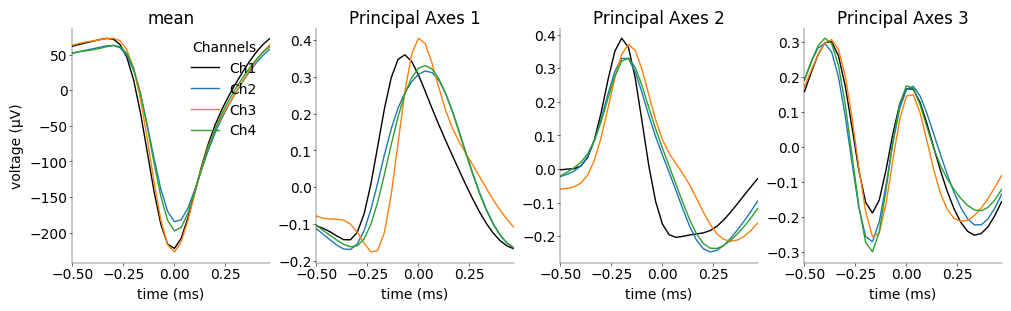

In [65]:
"""Solution"""

# ------------------------------------------------------------------------------------------------------------------
# Plot the mean of each channel and the three principal axes obtained by the PCA and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------------------------------------------

all_spikes = s
all_waveforms = extract_waveforms(x=filtered_signal, s=all_spikes)
features, means, pcs = extract_features(w=all_waveforms)

mosaic = [
    ["mean", "Principal Axes 1", "Principal Axes 2", "Principal Axes 3"],
]
colors = ["black", "tab:blue", "tab:orange", "tab:green"]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(10, 3), layout="constrained", dpi=100
)

for channel in range(4):
    color = colors[channel]

    # Mean waveform
    ax["mean"].plot(time_vector, means[channel], color=color, label=f"Ch{channel+1}")

    # Principal components
    ax["Principal Axes 1"].plot(time_vector, pcs[channel, 0], color=color)
    ax["Principal Axes 2"].plot(time_vector, pcs[channel, 1], color=color)
    ax["Principal Axes 3"].plot(time_vector, pcs[channel, 2], color=color)

# Formatting
for key in mosaic[0]:
    ax[key].set_xlabel("time (ms)")
    ax[key].set_xlim(time_vector[0], time_vector[-1])
    ax[key].set_title(key)

ax["mean"].set_ylabel("voltage (μV)")
ax["mean"].legend(title="Channels", loc="upper right")
plt.show()

### Questions

1) Compare the plot to the plots of the other tasks. What do you observe?

**Answer:**

We observe that the mean captures the overall shape of the largest spikes in a smooth and canonical form. The first principal axis then captures the primary location of the spike while subsequent access encode finer details not captured by first principal component.

2) What does the mean look like? Does this match your expectations?

**Answer:**

The mean spike, does capture the overall spike shape compared to the pictures of task-3 which plot the 100 largest and 100 earliest spikes. However the peaks shown have lower 
magnitude than the largest peaks as is expected from averaging over multiple spike snippets, some of which may contain faintly detected spikes and outliers.


3) Explain what it means if a spike has a high value in the first dimension. What is the effect of the other dimensions?

**Answer:**

A spike that has a large (positive or negative) coefficient on the first PCA dimension aligns strongly with the first principal axis—the canonical spike template—so it is essentially a large-amplitude spike that looks very much like the average shape.

The scores on the second and third dimensions are independent of PC 1; they describe variability that PC 1 cannot explain, such as differences in spike width, slight time shifts, or small pre-/post-potentials. These dimensions fine-tune the shape but do not change the basic “big vs. small” distinction captured by PC 1.



In [66]:
pcs_dict = {"Ch1": pcs[0], "Ch2": pcs[1], "Ch3": pcs[2], "Ch4": pcs[3]}

Text(0.5, 0.98, 'Pairwise 1st PCs')

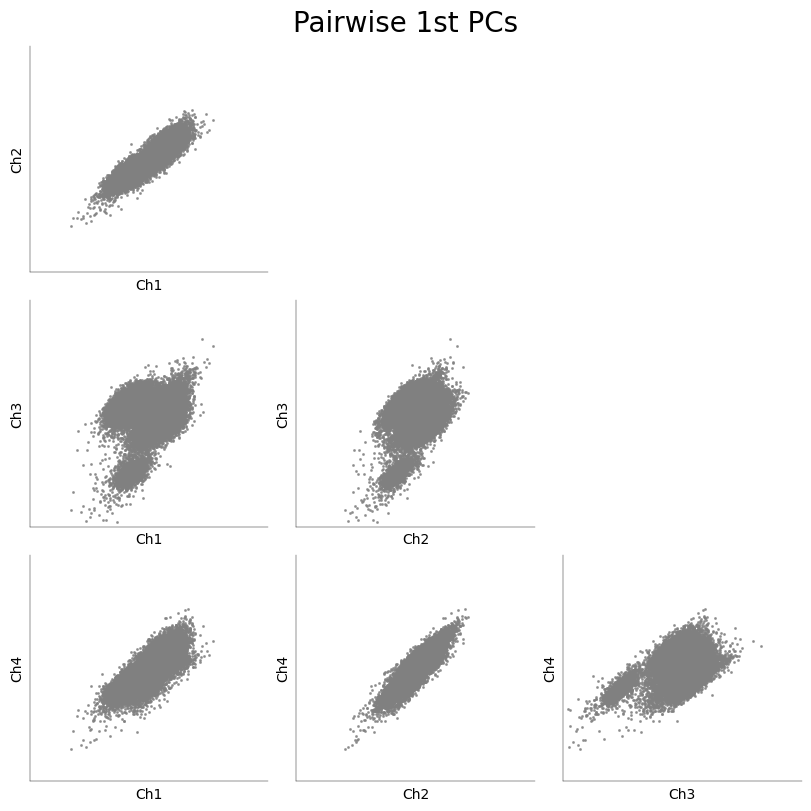

In [67]:
"""Solution"""

# ----------------------------------------------------------------------------------------------------------
# Create a scatterplot of the projections of the spikes for all pairwise combinations of the 1st PCs (1 pt)
# ----------------------------------------------------------------------------------------------------------

mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# index of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}
pcs_dict = {ch: features[:, idx] for ch, idx in i.items()}

for mo in np.ravel(mosaic):
    if mo == ".":
        continue
    y, x = mo.split(" vs ")

    ax[mo].scatter(x=pcs_dict[x], y=pcs_dict[y], s=5, alpha=0.7, color="grey")

    ax[mo].set_xlabel(x)
    ax[mo].set_ylabel(y)
    ax[mo].set_xlim((-1500, 1500))
    ax[mo].set_ylim((-1500, 1500))
    ax[mo].set_xticks([])
    ax[mo].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

In [68]:
# save data for the next Coding Lab

np.save("../data/nds_cl_1_features", features)
np.save("../data/nds_cl_1_spiketimes_s", s)
np.save("../data/nds_cl_1_spiketimes_t", t)
np.save("../data/nds_cl_1_waveforms", all_waveforms)